# Intro

## Load and import CapsNet

First, let's clone our GitHub repo and import all parts which will be used in this notebook.

In [0]:
!pip install -q --no-cache-dir --upgrade git+https://github.com/tumido/face_biometrics_descriptor-code.git
  
from sklearn.datasets import fetch_lfw_people
from capsnet import preprocess, CapsNet, fetch_pins_people

Using TensorFlow backend.


## Auxilary imports

Additional imports used in this Notebook would help to visualize data.

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

!pip install -q kaggle
from getpass import getpass

Install and start a TensorBoard in Colab

In [0]:
!pip install -q tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc = TensorBoardColab()
tensor_board_callback = TensorBoardColabCallback(tbc, batch_size=10, histogram_freq=5, write_graph=True, write_grads=True, write_images=True)

Wait for 8 seconds...
TensorBoard link:
https://b5522017.ngrok.io


## Verify GPU

in the next cell we verify that a GPU is available to our use. The output should contain a GPU details.

In [0]:
from tensorflow.test import is_gpu_available
from tensorflow.python.client import device_lib

if not is_gpu_available():
    raise SystemError('GPU device not found')

desc = [f'path: {d.name}, {d.physical_device_desc}' for d in device_lib.list_local_devices() if d.device_type == "GPU"][0]
print("\n".join(desc.split(", ")))

path: /device:GPU:0
device: 0
name: Tesla T4
pci bus id: 0000:00:04.0
compute capability: 7.5


## Collect data set 

This Notebook allows you to work with 2 different datasets: [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW, collected via `scikit-learn`) and a Kaggle dataset [Aligned Face Dataset from Pinterest](https://www.kaggle.com/frules11/pins-face-recognition). This dataset is collected in similar fashon as the LFW, however it needs your credentials to Kaggle to access it.

If you select to use a dataset from Kaggle, you need to authenticate first. Please pass your API token credentials.

In [0]:
dataset = input('Which dataset to use?\n1) Labeled Faces in the Wild (default)\n2) Aligned Face Dataset from Pinterest\n')

if dataset is '2':
    user = input('Kaggle Username: ')
    key = getpass('Kaggle API key: ')

    kaggle_json = f'{{"username":"{user}","key":"{key}"}}'

    !mkdir -p /root/.kaggle
    with open('/root/.kaggle/kaggle.json', 'w') as f:
        f.write(kaggle_json)

    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle config set -n path -v /content/kaggle
    !mkdir -p /content/kaggle

In [0]:
if dataset is '2':
    people = fetch_pins_people(
        color=True,
        min_faces_per_person=110  # Limit number of identities to ~50 (network is to large otherwise)
    )
    
else:
    people = fetch_lfw_people(
        color=True,
        min_faces_per_person=25
    )


data = preprocess(people)
(x_train, y_train), (x_test, y_test) = data

In [0]:
metrics = {
    "Identities": len(np.unique(people.target, axis=0)),
    "Total images": people.target.shape[0],
    "Train images": len(y_train),
    "Test images": len(y_test),
    "Image shape": x_train.shape[1:]
}
pd.DataFrame.from_dict(metrics, columns=["Value"], orient='index')

,Value
Identities,34
Total images,2370
Train images,1896
Test images,474
Image shape,"(32, 32, 3)"


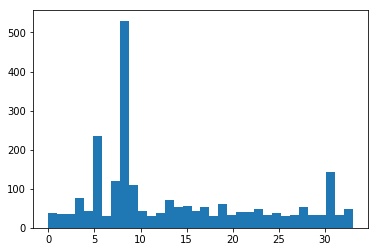

In [0]:
_ = plt.hist(people.target, bins=people.target_names.shape[0])

5: Colin Powell


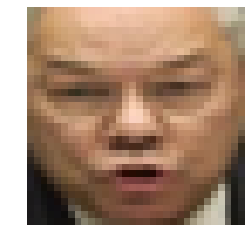

In [0]:
i = randint(0, len(x_train))
plt.imshow(x_train[i])
plt.axis('off') 
print("{}: {}".format(np.argmax(y_train[i]), people.target_names[np.argmax(y_train[i])]))

## CapsNet

Let's begin training our network

In [0]:
model = CapsNet(
    x_train.shape[1:],
    len(np.unique(y_train, axis=0))
)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv2d (Conv2D)         (None, 24, 24, 256)  62464       input_image[0][0]                
__________________________________________________________________________________________________
encoder_dropout (Dropout)       (None, 24, 24, 256)  0           encoder_conv2d[0][0]             
__________________________________________________________________________________________________
encoder_feature_caps_

In [0]:
history = model.train(data, batch_size=10, extra_callbacks=[tensor_board_callback])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/200
190/189 [==============================] - 72s 381ms/step - loss: 0.7997 - capsnet_loss: 0.7996 - decoder_loss: 0.2655 - capsnet_acc: 0.0400 - val_loss: 0.8101 - val_capsnet_loss: 0.8100 - val_decoder_loss: 0.1939 - val_capsnet_acc: 0.0148

Epoch 00001: val_capsnet_acc improved from -inf to 0.01477, saving model to model/weights.01.h5
Epoch 2/200
190/189 [==============================] - 72s 381ms/step - loss: 0.8082 - capsnet_loss: 0.8081 - decoder_loss: 0.1516 - capsnet_acc: 0.0146 - val_loss: 0.7982 - val_capsnet_loss: 0.7982 - val_decoder_loss: 0.0995 - val_capsnet_acc: 0.0633

Epoch 00002: val_capsnet_acc improved from 0.01477 to 0.06329, saving model to model/weights.02.h5
Epoch 3/200
190/189 [==============================] - 73s 385ms/step - loss: 0.7957 - capsnet_loss: 0.7957 - decoder_loss: 0.0883 - capsnet_acc: 0.0568 - val_loss: 0.7987 -

## Results of training

Let's see how our accuracy evolved during training.

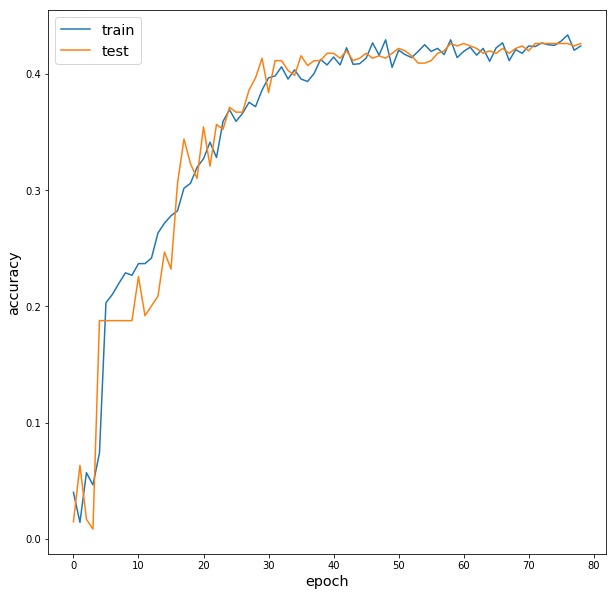

In [0]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['capsnet_acc'])
plt.plot(history.history['val_capsnet_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')

## Save trained model

Let's save our trained model into your [Google Drive](https://drive.google.com/drive/my-drive) first. The following cell will request permissions to access your Drive and then save the model as `model.h5`.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

model.save_weights('/content/gdrive/My Drive/model.h5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Saving model's weights to "/content/gdrive/My Drive/model.h5"... Done


## Testing

In [0]:
metrics = model.test(x_test, y_test, )
pd.DataFrame.from_dict(metrics, columns=["Value"], orient='index')

474/474 [==============================] - 5s 10ms/step


,Value
loss,0.439142
acc,0.426160


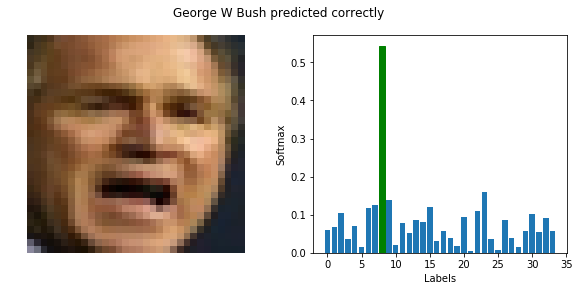

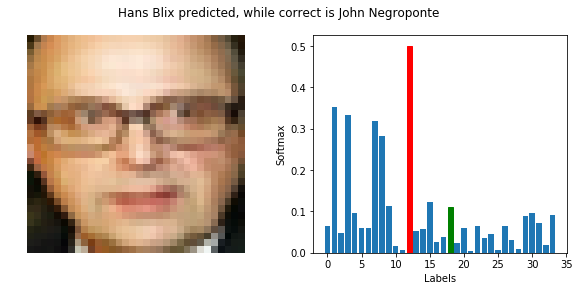

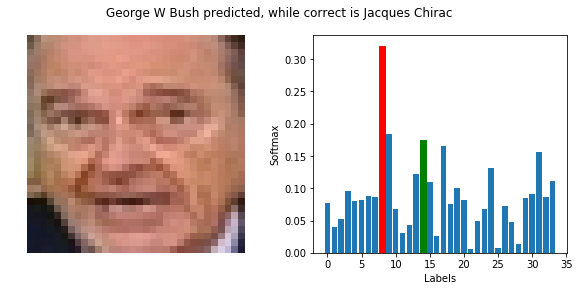

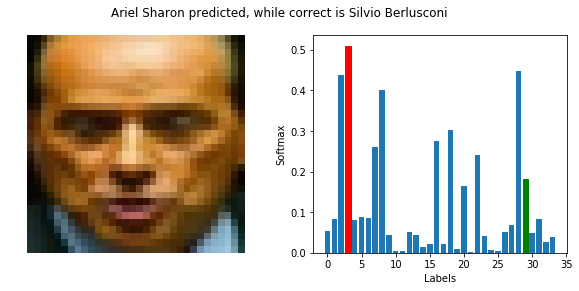

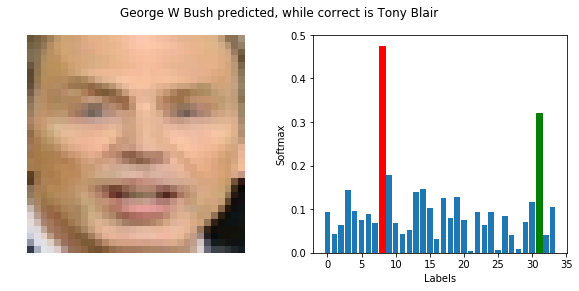

In [0]:
predictions = model.predict(x_test)


bins = len(np.unique(y_train, axis=0))
for j in range(10):
    i = randint(0, len(x_test))
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.subplots_adjust(hspace=1)
    axs = axs.ravel()
    predicted_idx = np.argmax(predictions[i])
    real_idx = np.argmax(y_test[i])

    axs[0].axis('off')
    axs[0].imshow(x_test[i])
    predicted_name = people.target_names[predicted_idx]
    real_name = people.target_names[real_idx]

    bars = axs[1].bar(np.arange(bins), predictions[i])
    axs[1].set_ylabel("Softmax")
    axs[1].set_xlabel("Labels")
    bars[predicted_idx].set_color('r')
    bars[real_idx].set_color('g')
    if predicted_idx == real_idx:
        fig.suptitle("%s predicted correctly" % predicted_name)
    else:
        fig.suptitle("%s predicted, while correct is %s" % (predicted_name, real_name))

plt.show()

In [0]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(0, len(classes), 1)
    plt.xticks(tick_marks, classes[tick_marks], rotation=90)
    plt.yticks(tick_marks, classes[tick_marks])
    plt.ylabel('True label', fontsize='x-large')
    plt.xlabel('Predicted label', fontsize='x-large')

y_pred = np.argmax(predictions, axis=1)
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, classes=people.target_names)
plt.grid(False)

In [0]:
def plot_barh(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('accuracy', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(np.mean(values), color='green', linewidth=2)
    plt.tight_layout()
    
class_accuracies = [cm[i, i] for i in range(cm.shape[0])]
plot_barh(people.target_names, class_accuracies)
print('average accuracy: {}%'.format(np.round(np.mean(class_accuracies) * 100.0, 1)))